In [0]:
from google.colab import drive
drive.mount('gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
# Reading data
df = pd.read_csv('gdrive/My Drive/data/preprocessed_data.csv',nrows=50000)
df=pd.DataFrame(df)
print(df['project_is_approved'].value_counts())


1    41993
0     8007
Name: project_is_approved, dtype: int64


# FINDING SENSITIVITY SCORES FOR PROJECT ESSAYS

In [0]:
data=df
l1=[]
l2=[]
l3=[]
l4=[]
sid = SentimentIntensityAnalyzer()
for i in range(0,len(data)):
    for_sentiment = data['essay'][i]
    ss = sid.polarity_scores(for_sentiment)
    l1.append(ss.get('neg'))
    l2.append(ss.get('neu'))
    l3.append(ss.get('pos'))
    l4.append(ss.get('compound'))
data['neg']=l1 
data['neu']=l2
data['pos']=l3
data['compound']=l4
print(data.head(3))

  school_state teacher_prefix project_grade_category  ...    neu    pos compound
0           ca            mrs          grades_prek_2  ...  0.783  0.205   0.9867
1           ut             ms             grades_3_5  ...  0.680  0.248   0.9897
2           ca            mrs          grades_prek_2  ...  0.721  0.262   0.9860

[3 rows x 13 columns]


In [0]:
import numpy as np
print(np.unique(data.project_grade_category))
print(np.unique(data.teacher_prefix))

['grades_3_5' 'grades_6_8' 'grades_9_12' 'grades_prek_2']
['dr' 'mr' 'mrs' 'ms' 'teacher']


In [0]:
y = data['project_is_approved'].values
x=data.drop('project_is_approved',axis=1)
print(x.columns)


Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'neg', 'neu', 'pos',
       'compound'],
      dtype='object')


In [0]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)
print(X_train.shape)


(37500, 12)


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re



from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter




## Encoding categorical features

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
l=[]
vectorizer = CountVectorizer(min_df=5,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['school_state'].values)
l.extend(vectorizer.get_feature_names())
print(len(l))
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
#X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)
print(X_train_state_ohe.shape)

vectorizer = CountVectorizer(min_df=5,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['teacher_prefix'].values)
l.extend(vectorizer.get_feature_names())
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
#X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)
print(X_train_teacher_ohe.shape)
print(len(l))

51
(37500, 51)
(37500, 4)
55


In [0]:
vectorizer = CountVectorizer(min_df=5,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['project_grade_category'].values)
l.extend(vectorizer.get_feature_names())
print(len(l))
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
#X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)
print(X_train_grade_ohe.shape)

59
(37500, 4)


In [0]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)
l.extend(vectorizer.get_feature_names())
print(len(l))
X_train_subject_ohe = vectorizer.transform(X_train['clean_categories'].values)
#X_cv_subject_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_subject_ohe = vectorizer.transform(X_test['clean_categories'].values)
print(X_train_subject_ohe.shape)

68
(37500, 9)


In [0]:
vectorizer = CountVectorizer(min_df=5,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['clean_subcategories'].values)
l.extend(vectorizer.get_feature_names())
X_train_subject_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
#X_cv_subject_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subject_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)
print(X_train_subject_subcategories_ohe.shape)
print(len(l))

(37500, 238)
306


## Encoding numerical features

In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))
l.append('price')
X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
#X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))
print(X_train_price_norm.shape)
print(len(l))


(37500, 1)
307


In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
l.append('teacher_number_of_previously_posted_projects')
X_train_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#X_cv_previously_posted_projects_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(len(l))


308


In [0]:
print(X_train_previously_posted_projects_norm.shape)

(37500, 1)


In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['neg'].values.reshape(-1,1))
l.append('neg')
X_train_neg_norm = normalizer.transform(X_train['neg'].values.reshape(-1,1))
#X_cv_neg_norm = normalizer.transform(X_cv['neg'].values.reshape(-1,1))
X_test_neg_norm = normalizer.transform(X_test['neg'].values.reshape(-1,1))
print(X_train_neg_norm.shape)
print(len(l))

(37500, 1)
309


In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['neu'].values.reshape(-1,1))
l.append('neu')
X_train_neu_norm = normalizer.transform(X_train['neu'].values.reshape(-1,1))
#X_cv_neu_norm = normalizer.transform(X_cv['neu'].values.reshape(-1,1))
X_test_neu_norm = normalizer.transform(X_test['neu'].values.reshape(-1,1))
print(X_train_neu_norm.shape)
print(len(l))


(37500, 1)
310


In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['pos'].values.reshape(-1,1))
l.append('pos')
X_train_pos_norm = normalizer.transform(X_train['pos'].values.reshape(-1,1))
#X_cv_pos_norm = normalizer.transform(X_cv['pos'].values.reshape(-1,1))
X_test_pos_norm = normalizer.transform(X_test['pos'].values.reshape(-1,1))
print(X_train_price_norm.shape)
print(len(l))


(37500, 1)
311


In [0]:
normalizer = Normalizer()
normalizer.fit(X_train['compound'].values.reshape(-1,1))
l.append('compound')
X_train_compound_norm = normalizer.transform(X_train['compound'].values.reshape(-1,1))
#X_cv_compound_norm = normalizer.transform(X_cv['compound'].values.reshape(-1,1))
X_test_compound_norm = normalizer.transform(X_test['compound'].values.reshape(-1,1))
print(X_train_price_norm.shape)
print(len(l))

(37500, 1)
312


## Encoding Text Features(project essays)

In [0]:

vectorizer = TfidfVectorizer(min_df=5)
vectorizer.fit(X_train['essay'].values)
tfidf_essay_feat=(vectorizer.get_feature_names())
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
#X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)





vectorizer = CountVectorizer(min_df=5,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values)
bow_essay_feat=(vectorizer.get_feature_names())
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
#X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)
print(X_train_essay_bow.shape)



(37500, 5000)


In [0]:
print(len(bow_essay_feat))

5000


In [0]:
l1=l+bow_essay_feat
print('NUMBER OF FEATURES IN BOW VETORIZER :',len(l1))

NUMBER OF FEATURES IN BOW VETORIZER : 5312


In [0]:
l2=l+tfidf_essay_feat
print('NUMBER OF FEATURES IN TFIDF VETORIZER :',len(l2))

NUMBER OF FEATURES IN TFIDF VETORIZER : 15011


#  <h1><center>[SET 1]BOW VECTORIZER</center></h1>

## Concatinating all the features

In [0]:
from scipy.sparse import hstack
X_tr = hstack((X_train_grade_ohe,X_train_subject_ohe,X_train_subject_subcategories_ohe,X_train_previously_posted_projects_norm,X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_price_norm,X_train_neg_norm,X_train_neu_norm,X_train_pos_norm,X_train_compound_norm)).tocsr()
X_cv = hstack((X_cv_grade_ohe,X_cv_subject_ohe,X_cv_subject_subcategories_ohe,X_cv_essay_bow,X_cv_previously_posted_projects_norm, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_price_norm,X_cv_neg_norm,X_cv_neu_norm,X_cv_pos_norm,X_cv_compound_norm)).tocsr()
X_te = hstack((X_test_grade_ohe,X_test_subject_ohe,X_test_subject_subcategories_ohe,X_test_previously_posted_projects_norm, X_test_essay_bow,X_test_state_ohe, X_test_teacher_ohe, X_test_price_norm,X_test_neg_norm,X_test_neu_norm,X_test_pos_norm,X_test_compound_norm)).tocsr()
print(X_tr.shape)

(37500, 5312)


In [0]:
print(X_te.shape)

(12500, 5312)


# Hyperparameter tuning

In [0]:
from sklearn.model_selection import GridSearchCV
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(min_samples_split=50,min_samples_leaf=50,class_weight='balanced')
parameters={'max_depth':[1,5,10,50,100]}
clf=GridSearchCV(dt,parameters,cv=5,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=50,
                                              min_samples_split=50,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

In [0]:
results=pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])


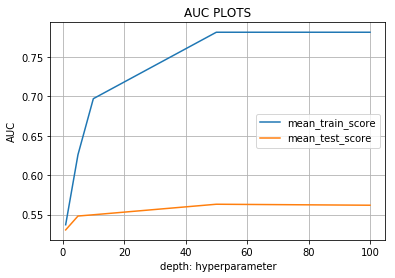

In [0]:
k=results['param_max_depth']
y1=results['mean_train_score']
y2=results['mean_test_score']
plt.plot(k,y1)
plt.plot(k,y2)
plt.legend()
plt.xlabel("depth: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

In [0]:
clf.best_params_

{'max_depth': 50}

In [0]:
from sklearn.model_selection import GridSearchCV
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(min_samples_split=50,min_samples_leaf=230,class_weight='balanced')
parameters={'min_samples_split':[5,10,100,500]}
clf=GridSearchCV(dt,parameters,cv=5,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=230,
                                              min_samples_split=50,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': [5, 10, 100, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_trai

In [0]:
results=pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_min_samples_split'])

0    0.651249
1    0.651249
2    0.651249
3    0.650250
Name: mean_train_score, dtype: float64


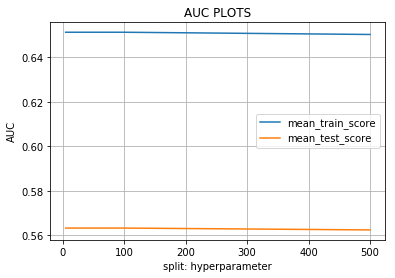

In [0]:
k=results['param_min_samples_split']


y1=results['mean_train_score']
print(y1)
y2=results['mean_test_score']
plt.plot(k,y1)
plt.plot(k,y2)
plt.legend()
plt.xlabel("split: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

In [0]:
clf.best_params_

{'min_samples_split': 5}

In [0]:
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(min_samples_split=50,min_samples_leaf=230,class_weight='balanced')
parameters={'min_samples_split':[5,10,100,500],'max_depth':[1,5,10,50,100]}
clf=GridSearchCV(dt,parameters,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=230,
                                              min_samples_split=50,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100],
                         'min_samples_split': [5, 10, 100, 500]},
  

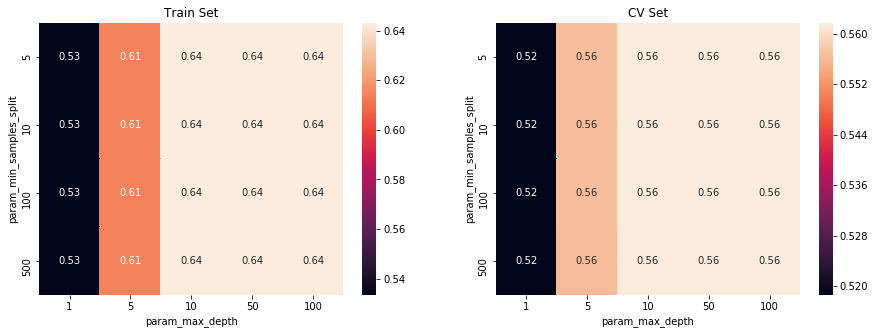

In [0]:
max_scores=pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split','param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(max_scores.mean_train_score,annot=True,fmt='.2g',ax=ax[0])
sns.heatmap(max_scores.mean_test_score,annot=True,fmt='.2g',ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

## The best DEPTH is selected based on maximum CV AUC and minimum difference between train and test accuracy as DEPTH=500 AND SPLIT=500

In [0]:
import math
from sklearn import tree
from sklearn.metrics import roc_auc_score
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

# Fitting the model with best parameters

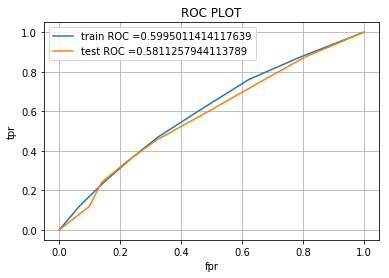

In [0]:
from sklearn.metrics import roc_curve, auc
from  sklearn.tree import DecisionTreeClassifier as dt

dt = tree.DecisionTreeClassifier(max_depth=500,min_samples_split=500,min_samples_leaf=780,class_weight ='balanced')
dt.fit(X_tr, y_train)

y_train_pred = batch_predict(dt, X_tr)    
y_cv_pred = batch_predict(dt, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_cv_pred)

plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC PLOT")
plt.grid()
plt.show()

# TREE VISUALIZATION for Bag Of Words

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

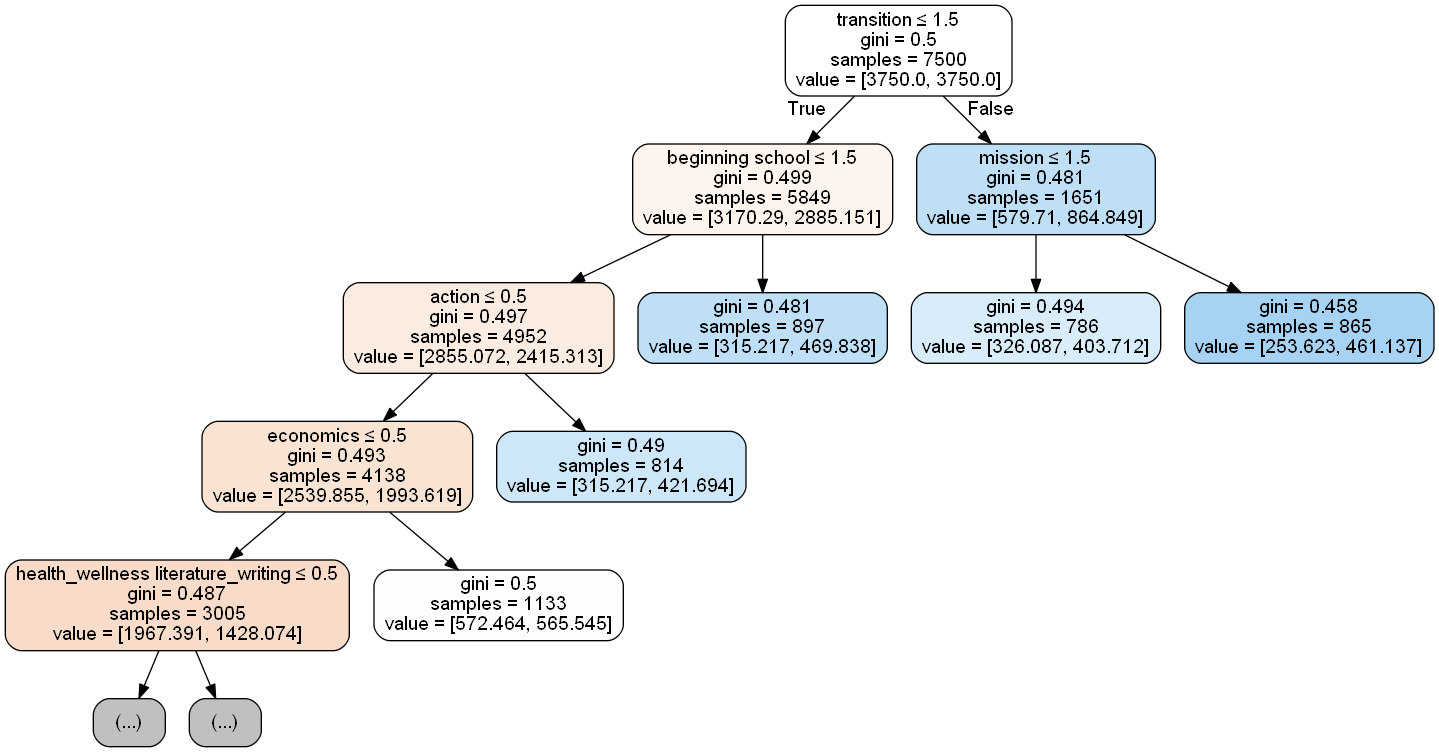

In [0]:
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names=l1,max_depth=4)
                
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [0]:
# function to find best threshold for ROC plot

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr) is =", max(tpr*(1-fpr)), "for threshold =", np.round(t,3))
    return t
# function to predict 'y' with best threshold
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) is = 0.3448568958189839 for threshold = 0.511
FALSE POSITIVES INDICES 781


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

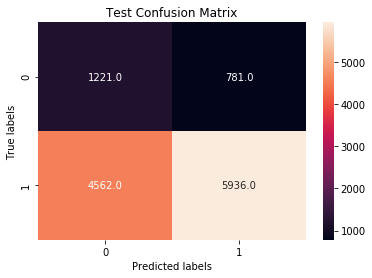

In [0]:
labels = [0, 1]
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
pred=predict_with_best_t(y_cv_pred, best_t)
b=confusion_matrix(y_test,pred, labels)
I=set()
for i in range(0,len(y_test)):
    if pred[i]==1 and y_test[i]==0:
        I.add(i) 
print('FALSE POSITIVES INDICES',len(I))
     
ax= plt.subplot()
sns.heatmap(b, annot=True, fmt='.1f',ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Test Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1]); ax.yaxis.set_ticklabels([0,1])

## Finding the false positives indices

In [0]:
#find the false positives of essay,price and teacher previously submitted projets
fp_essay=[]
fp_price=[]
fp_previous_projects=[]
for i in I:
    fp_essay.append(X_test.iloc[i].essay.split(" "))
    fp_price.append(X_test.iloc[i].price)
    fp_previous_projects.append(X_test.iloc[i].teacher_number_of_previously_posted_projects)

fp_price=np.asarray(fp_price)

fp_previous_projects=np.asarray(fp_previous_projects)

## Plotting Word cloud for false positives words

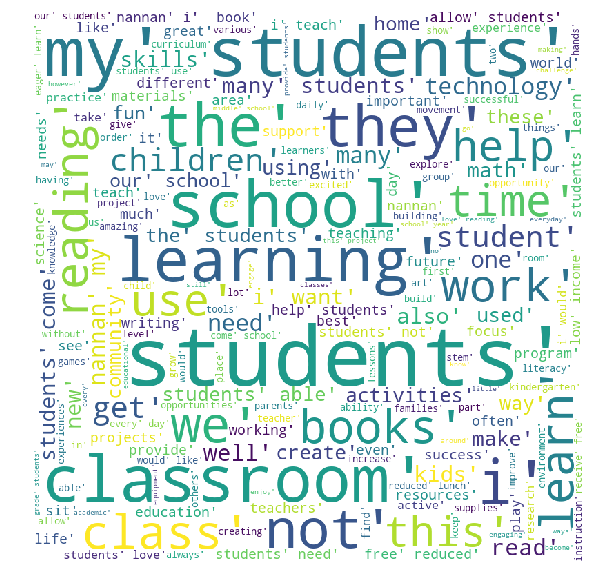

In [0]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in fp_essay:
    val = str(val)
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    for words in tokens: 
        comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 5).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)      
plt.show()

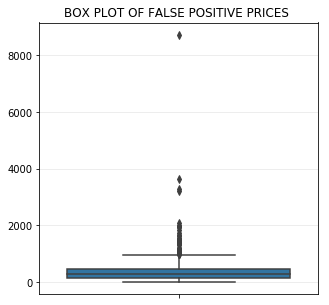

In [0]:
import seaborn as sns
fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

a=sns.boxplot(y=fp_price).set_title('BOX PLOT OF FALSE POSITIVE PRICES ')



plt.show()

# Box plot shows that mean of false positive 'price' is around 500,indicating that our model goes wrong there

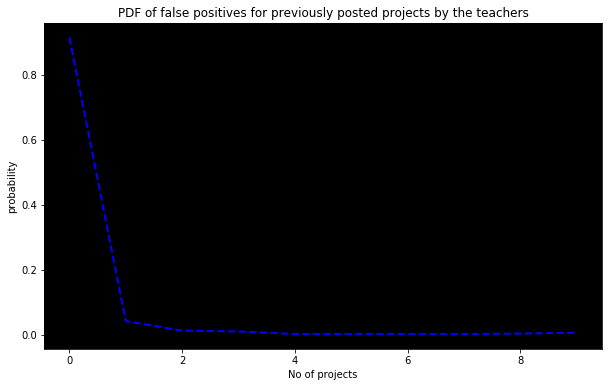

In [0]:
counts, bin_edges = np.histogram(fp_previous_projects, bins=10, 
                                 density = True)
pdf=counts/sum(counts)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('black')
plt.plot(pdf,'--b',linewidth=2)
plt.xlabel('No of projects')
plt.ylabel('probability')
plt.title(label='PDF of false positives for previously posted projects by the teachers')
plt.show()

##  <h1><center>[Set 2]TFIDF VECTORIZER</center></h1>

# Using TFIDF as featurization

In [0]:
#CONCATINATING ALL THE FEATURES
X_tr = hstack((X_train_grade_ohe,X_train_subject_ohe,X_train_subject_subcategories_ohe,X_train_previously_posted_projects_norm,X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_price_norm,X_train_neg_norm,X_train_neu_norm,X_train_pos_norm,X_train_compound_norm)).tocsr()
X_cv = hstack((X_cv_grade_ohe,X_cv_subject_ohe,X_cv_subject_subcategories_ohe,X_cv_essay_tfidf,X_cv_previously_posted_projects_norm, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_price_norm,X_cv_neg_norm,X_cv_neu_norm,X_cv_pos_norm,X_cv_compound_norm)).tocsr()
X_te = hstack((X_test_grade_ohe,X_test_subject_ohe,X_test_subject_subcategories_ohe,X_test_essay_tfidf,X_test_previously_posted_projects_norm, X_test_state_ohe, X_test_teacher_ohe, X_test_price_norm,X_test_neg_norm,X_test_neu_norm,X_test_pos_norm,X_test_compound_norm)).tocsr()
print(X_tr.shape)

(37500, 15011)


# Hyperparameter tuning

In [0]:
from sklearn.model_selection import GridSearchCV
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(min_samples_split=400,min_samples_leaf=50,class_weight='balanced')
parameters={'max_depth':[1,5,10,50,100,500,1000]}
clf=GridSearchCV(dt,parameters,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)


In [0]:
results=pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])


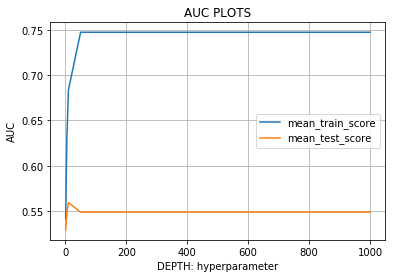

In [0]:
k=results['param_max_depth']
y1=results['mean_train_score']
y2=results['mean_test_score']
plt.plot(k,y1)
plt.plot(k,y2)
plt.legend()
plt.xlabel("DEPTH: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

In [0]:
clf.best_params_

{'max_depth': 10}

In [0]:
from sklearn.model_selection import GridSearchCV
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(max_depth=50,min_samples_leaf=50,class_weight='balanced')
parameters={'min_samples_split':[5,10,100,500]}
clf=GridSearchCV(dt,parameters,cv=5,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=50,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=50,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': [5, 10, 100, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_sc

In [0]:
results=pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_min_samples_split'])

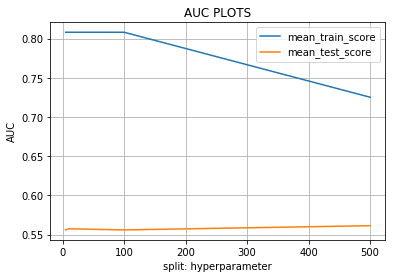

In [0]:
k=results['param_min_samples_split']
y1=results['mean_train_score']
y2=results['mean_test_score']
plt.plot(k,y1)
plt.plot(k,y2)
plt.legend()
plt.xlabel("split: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

In [0]:
clf.best_params_

{'min_samples_split': 500}

In [0]:
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(min_samples_split=50,min_samples_leaf=230,class_weight='balanced')
parameters={'min_samples_split':[5,10,100,500],'max_depth':[1,5,10,30,50,100],'min_samples_leaf':[250]}
clf=GridSearchCV(dt,parameters,cv=3,scoring='roc_auc',return_train_score=True)
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

clf.fit(X_tr,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=230,
                                              min_samples_split=50,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 30, 50, 100],
                         'min_samples_leaf': [250],
            

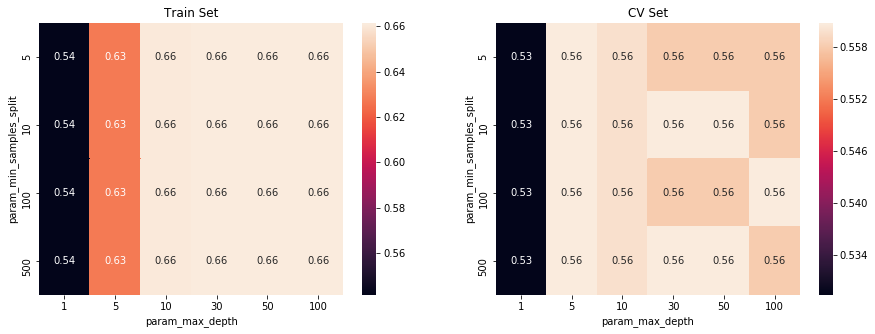

In [0]:
max_scores=pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split','param_max_depth',]).max().unstack()[['mean_test_score', 'mean_train_score']]
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(max_scores.mean_train_score,annot=True,fmt='.2g',ax=ax[0])
sns.heatmap(max_scores.mean_test_score,annot=True,fmt='.2g',ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

## The best DEPTH is selected based on maximum CV AUC and minimum difference between train and test accuracy as DEPTH=100 and SPLIT=5

# Fitting the best hyperparameters

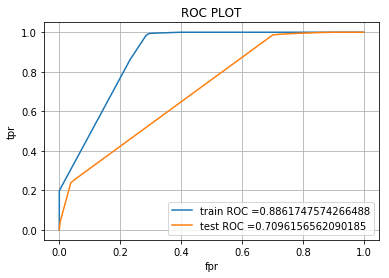

In [0]:
from sklearn.metrics import roc_curve, auc

dt = tree.DecisionTreeClassifier(max_depth=100,min_samples_split=5)
dt.fit(X_tr, y_train)


y_train_pred = batch_predict(dt, X_tr)    
y_cv_pred = batch_predict(dt, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_cv_pred)

plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC PLOT")
plt.grid()
plt.show()

# TREE VISUALIZATION for  TFIDF

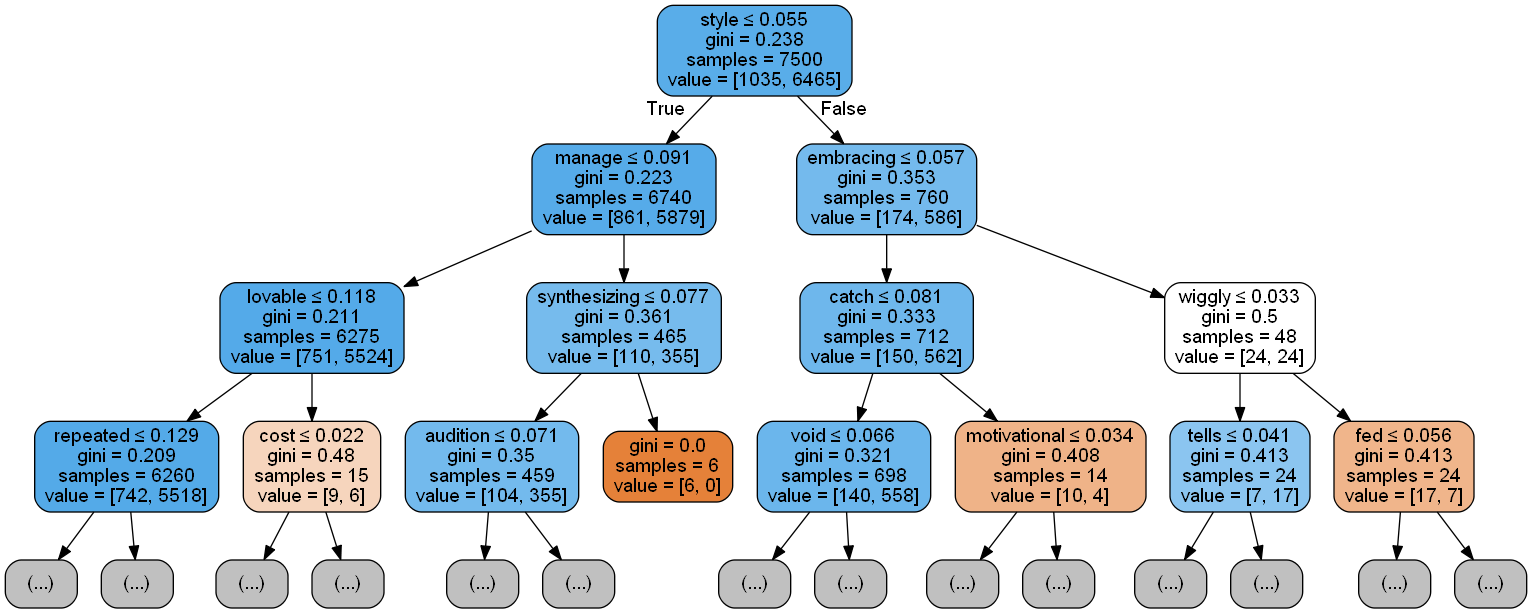

In [0]:
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True,max_depth=3,feature_names=l2)
                
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

the maximum value of tpr*(1-fpr) is = 0.06437109280508027 for threshold = 1.0


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

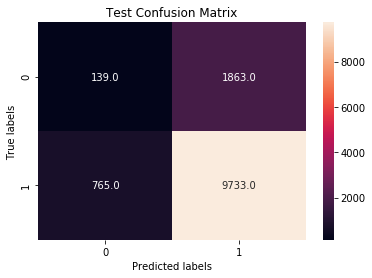

In [75]:
#PLOTTING TEST CONFUSION MATRIX
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
pred=predict_with_best_t(y_cv_pred, best_t)
b=confusion_matrix(y_test,pred, labels)

ax= plt.subplot()
sns.heatmap(b, annot=True, fmt='.1f',ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Test Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1]); ax.yaxis.set_ticklabels([0,1])


## FINDING FALSE POSITIVES INDICES

In [76]:
I=set()
for i in range(0,len(y_test)):
    if pred[i]==1 and y_test[i]==0:
        I.add(i)    
print('Total number of false positives',len(I))

Total number of false positives 1863


## Finding the false positives

In [0]:
#find the false positives of essay,price and teacher previously submitted projets
fp_essay=[]
fp_price=[]
fp_previous_projects=[]
for i in I:
    fp_essay.append(X_test.iloc[i].essay.split(" "))
    fp_price.append(X_test.iloc[i].price)
    fp_previous_projects.append(X_test.iloc[i].teacher_number_of_previously_posted_projects)

fp_price=np.asarray(fp_price)

fp_previous_projects=np.asarray(fp_previous_projects)

## Plotting Word cloud of false positives

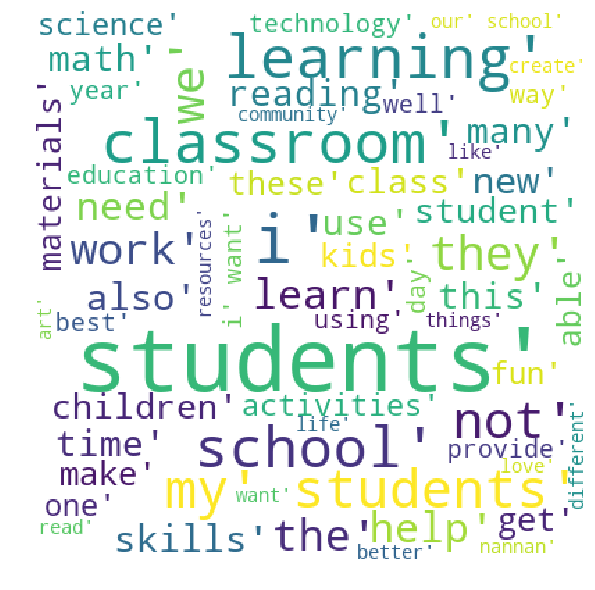

In [0]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in fp_essay:
    val = str(val)
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    for words in tokens: 
        comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 400, height = 400, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)      
plt.show()

## BOX PLOT

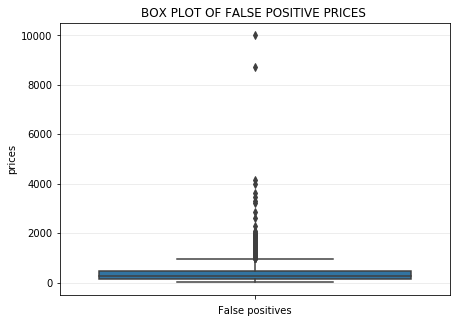

In [82]:
import seaborn as sns
fig, ax1 = plt.subplots(figsize=(7, 5))
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
a=sns.boxplot(y=fp_price).set_title('BOX PLOT OF FALSE POSITIVE PRICES ')
plt.ylabel('prices')
plt.xlabel('False positives')
plt.show()

## PDF

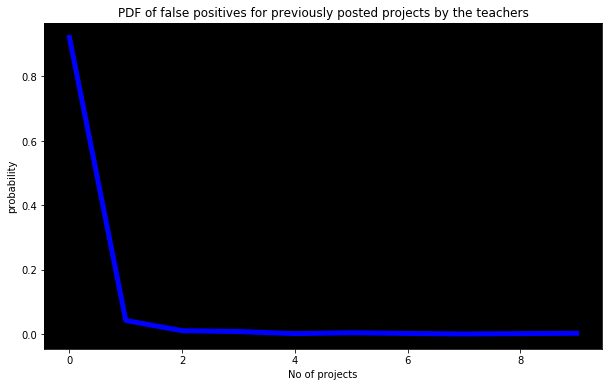

In [83]:
counts, bin_edges = np.histogram(fp_previous_projects, bins=10, 
                                 density = True)
pdf=counts/sum(counts)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('black')
plt.plot(pdf,'b',linewidth=5)
plt.xlabel('No of projects')
plt.ylabel('probability')
plt.title('PDF of false positives for previously posted projects by the teachers')
plt.show()

##  <h1><center>SET[3] AVG W2V</center></h1>

# Featurizing with glove vectors

In [2]:
import pickle
with open('gdrive/My Drive/data/glove_vectors','rb') as f:
    model=pickle.load(f)
    glove_vectors=set(model.keys()) 


In [3]:
glove_vectors

{'god',
 'corroboration',
 'acceed',
 'islam',
 'skyped',
 'grandkids',
 'breakers',
 'magnificient',
 'glint',
 'argentine',
 'decays',
 'homemaking',
 'i8',
 'ecoutez',
 'glares',
 'dewey',
 'experiance',
 'teleoperated',
 'fartsy',
 'reignites',
 'wonderkids',
 'inward',
 'sizzling',
 'fixtures',
 'comparisons',
 'doctor',
 'gladiators',
 'beutel',
 'maraca',
 'twistables',
 'beezus',
 'waxes',
 'melding',
 'shortened',
 'curls',
 'sway',
 'sery',
 'hurley',
 'cauliflower',
 'drinker',
 'vixia',
 'pathfinders',
 'honda',
 'talkies',
 'spicy',
 'chernobyl',
 'attract',
 'salvation',
 'omani',
 'iterate',
 'veiw',
 'fourt',
 'contributors',
 'powering',
 'personhood',
 'itrax',
 'owensboro',
 'sharable',
 'eread',
 'clyde',
 'sdaie',
 'councilors',
 'ebay',
 'ecozone',
 'inprove',
 'polos',
 'divide',
 'iers',
 'irreverent',
 'levelized',
 'horace',
 'blames',
 'gibbon',
 'encompass',
 'pedometers',
 'roddam',
 'francophone',
 'greenscreen',
 'rigorous',
 'festive',
 'seasonal',
 'reg

In [86]:
print(len(glove_vectors))

51510


In [87]:
l3=[]
avg_w2v_vectors_train=[]
for sentence in tqdm(X_train['essay']):
    vector=np.zeros(300)
    cnt_words=0
    for word in sentence.split(" "):
        if word in glove_vectors:
           
            vector=model[word]
            cnt_words+=1      
    if cnt_words!=0:
        vector/=cnt_words
    avg_w2v_vectors_train.append(vector)  
print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████| 37500/37500 [00:04<00:00, 9141.99it/s]

37500
300


In [88]:
l3=[]
avg_w2v_vectors_test=[]
for sentence in tqdm(X_test['essay']):
    vector=np.zeros(300)
    cnt_words=0
    for word in sentence.split(" "):
        if word in glove_vectors:
            
            vector=model[word]
            cnt_words+=1
    if cnt_words!=0:
        vector/=cnt_words
    avg_w2v_vectors_test.append(vector)  
print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████| 12500/12500 [00:01<00:00, 9454.00it/s]

12500
300


In [89]:
from scipy.sparse import csr_matrix as csr
avg_w2v_vectors_train=csr(avg_w2v_vectors_train)
avg_w2v_vectors_cv=csr(avg_w2v_vectors_cv)
avg_w2v_vectors_test=csr(avg_w2v_vectors_test)
print(avg_w2v_vectors_train.shape)

(37500, 300)


In [90]:
X_tr = hstack((X_train_grade_ohe,X_train_subject_ohe,X_train_subject_subcategories_ohe,X_train_previously_posted_projects_norm,avg_w2v_vectors_train, X_train_state_ohe, X_train_teacher_ohe, X_train_price_norm,X_train_neg_norm,X_train_neu_norm,X_train_pos_norm,X_train_compound_norm)).tocsr()
X_cv = hstack((X_cv_grade_ohe,X_cv_subject_ohe,X_cv_subject_subcategories_ohe,X_cv_previously_posted_projects_norm,avg_w2v_vectors_cv, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_price_norm,X_cv_neg_norm,X_cv_neu_norm,X_cv_pos_norm,X_cv_compound_norm)).tocsr()
X_te = hstack((X_test_grade_ohe,X_test_subject_ohe,X_test_subject_subcategories_ohe,X_test_previously_posted_projects_norm, avg_w2v_vectors_test,X_test_state_ohe, X_test_teacher_ohe, X_test_price_norm,X_test_neg_norm,X_test_neu_norm,X_test_pos_norm,X_test_compound_norm)).tocsr()
print(X_tr.shape)

(37500, 612)


# Hyperparameter Tuning

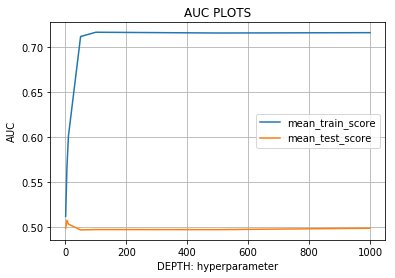

In [0]:

from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(min_samples_split=400,class_weight='balanced')
parameters={'max_depth':[1,5,10,50,100,500,1000]}
clf=GridSearchCV(dt,parameters,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)


results=pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])


k=results['param_max_depth']
y1=results['mean_train_score']
y2=results['mean_test_score']
plt.plot(k,y1)
plt.plot(k,y2)
plt.legend()
plt.xlabel("DEPTH: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

In [0]:
clf.best_params_

{'max_depth': 5}

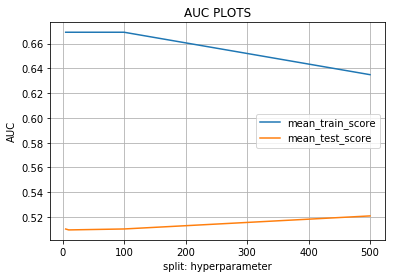

In [0]:
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(max_depth=50,min_samples_leaf=50,class_weight='balanced')
parameters={'min_samples_split':[5,10,100,500]}
clf=GridSearchCV(dt,parameters,cv=5,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)


results=pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_min_samples_split'])

k=results['param_min_samples_split']
y1=results['mean_train_score']
y2=results['mean_test_score']
plt.plot(k,y1)
plt.plot(k,y2)
plt.legend()
plt.xlabel("split: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

In [0]:
clf.best_params_

{'min_samples_split': 500}

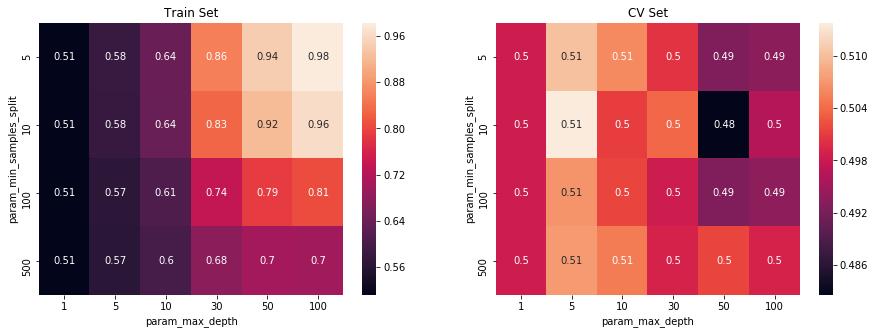

In [0]:
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(class_weight='balanced')
parameters={'min_samples_split':[5,10,100,500],'max_depth':[1,5,10,30,50,100]}
clf=GridSearchCV(dt,parameters,cv=3,scoring='roc_auc',return_train_score=True)


clf.fit(X_tr,y_train)

max_scores=pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split','param_max_depth',]).max().unstack()[['mean_test_score', 'mean_train_score']]
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(max_scores.mean_train_score,annot=True,fmt='.2g',ax=ax[0])
sns.heatmap(max_scores.mean_test_score,annot=True,fmt='.2g',ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

## The best DEPTH is selected based on maximum CV AUC and minimum difference between train and test accuracy as DEPTH=100 and SPLIT=10

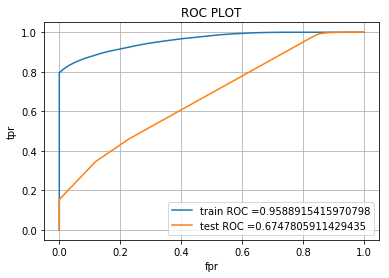

In [0]:
from sklearn.metrics import roc_curve, auc

dt = tree.DecisionTreeClassifier(max_depth=100,min_samples_split=10,class_weight='balanced')
dt.fit(X_tr, y_train)
y_train_pred = batch_predict(dt, X_tr)    
y_cv_pred = batch_predict(dt, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_cv_pred)

plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC PLOT")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) is = 0.2609796376228078 for threshold = 0.58


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

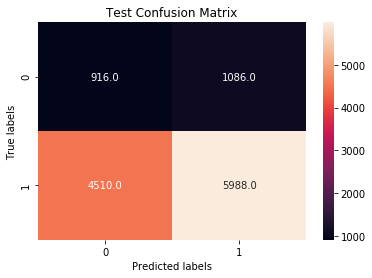

In [92]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
pred=predict_with_best_t(y_cv_pred, best_t)
b=confusion_matrix(y_test,pred, labels)

#PLOTTING TEST CONFUSION MATRIX
    
ax= plt.subplot()
sns.heatmap(b, annot=True, fmt='0.1f',ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Test Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1]); ax.yaxis.set_ticklabels([0,1])

In [93]:
## FINDING FALSE POSITIVES INDICES

I=set()
for i in range(0,len(y_test)):
    if pred[i]==1 and y_test[i]==0:
        I.add(i)    
print('Total number of false positives',len(I))

Total number of false positives 1086


## Finding the false positives 

In [0]:
#find the false positives of essay,price and teacher previously submitted projets
fp_essay=[]
fp_price=[]
fp_previous_projects=[]
for i in I:
    fp_essay.append(X_test.iloc[i].essay.split(" "))
    fp_price.append(X_test.iloc[i].price)
    fp_previous_projects.append(X_test.iloc[i].teacher_number_of_previously_posted_projects)

fp_price=np.asarray(fp_price)

fp_previous_projects=np.asarray(fp_previous_projects)

## Plotting Word cloud of false positive words

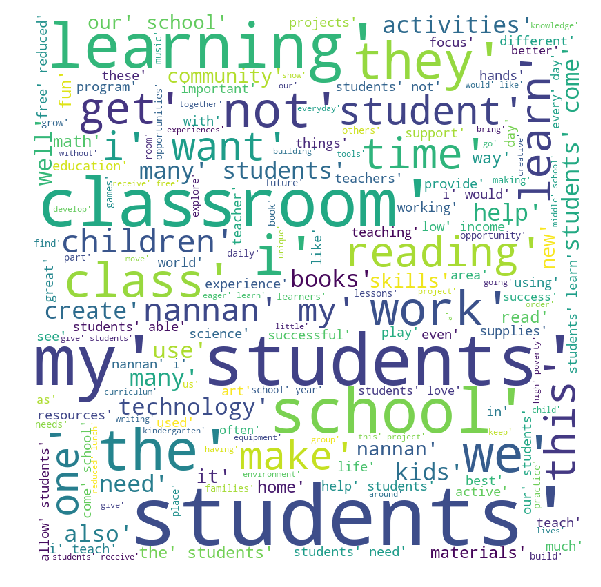

In [95]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in fp_essay:
    val = str(val)
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    for words in tokens: 
        comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)      
plt.show()

## BOX PLOT

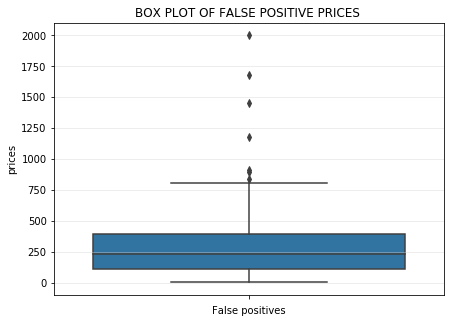

In [0]:
import seaborn as sns
fig, ax1 = plt.subplots(figsize=(7, 5))
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
a=sns.boxplot(y=fp_price).set_title('BOX PLOT OF FALSE POSITIVE PRICES ')
plt.ylabel('prices')
plt.xlabel('False positives')
plt.show()

## PDF

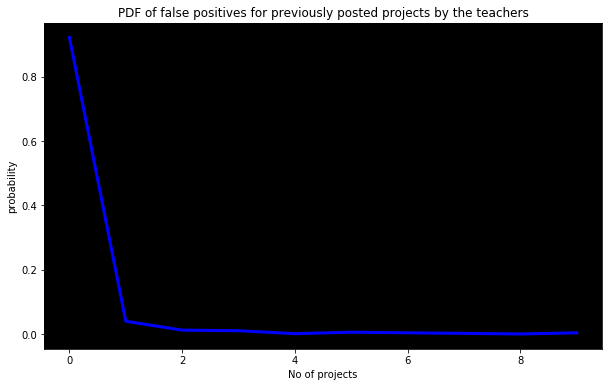

In [96]:
counts, bin_edges = np.histogram(fp_previous_projects, bins=10, 
                                 density = True)
pdf=counts/sum(counts)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('black')
plt.plot(pdf,'b',linewidth=3)
plt.xlabel('No of projects')
plt.ylabel('probability')
plt.title('PDF of false positives for previously posted projects by the teachers')
plt.show()

##  <h1><center>SET [4] TFIDF W2V</center></h1>

# Using glove vectors and TFIDF Word2Vec as featurization of text features

In [0]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


In [98]:
# compute tfidf word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_vectors) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|██████████| 37500/37500 [01:48<00:00, 345.61it/s]

37500
300


In [99]:
# compute tfidf word2vec for each review.
tfidf_w2v_vectors_test= []; 
for sentence in tqdm(X_test['essay']): 
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_vectors) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|██████████| 12500/12500 [00:35<00:00, 347.44it/s]

12500
300


In [100]:
avg_w2v_vectors_train=csr(avg_w2v_vectors_train)
avg_w2v_vectors_cv=csr(avg_w2v_vectors_cv)
avg_w2v_vectors_test=csr(avg_w2v_vectors_test)
print(avg_w2v_vectors_train.shape)

(37500, 300)


In [101]:
X_tr = hstack((X_train_grade_ohe,X_train_subject_ohe,X_train_subject_subcategories_ohe,X_train_previously_posted_projects_norm,avg_w2v_vectors_train, X_train_state_ohe, X_train_teacher_ohe, X_train_price_norm,X_train_neg_norm,X_train_neu_norm,X_train_pos_norm,X_train_compound_norm)).tocsr()
X_cv = hstack((X_cv_grade_ohe,X_cv_subject_ohe,X_cv_subject_subcategories_ohe,X_cv_previously_posted_projects_norm,avg_w2v_vectors_cv, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_price_norm,X_cv_neg_norm,X_cv_neu_norm,X_cv_pos_norm,X_cv_compound_norm)).tocsr()
X_te = hstack((X_test_grade_ohe,X_test_subject_ohe,X_test_subject_subcategories_ohe,X_test_previously_posted_projects_norm, avg_w2v_vectors_test,X_test_state_ohe, X_test_teacher_ohe, X_test_price_norm,X_test_neg_norm,X_test_neu_norm,X_test_pos_norm,X_test_compound_norm)).tocsr()
print(X_tr.shape)

(37500, 612)


# Hyperparameter Tuning

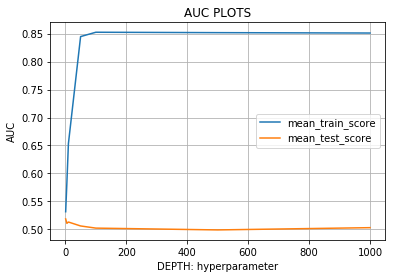

In [0]:
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(min_samples_split=50,class_weight='balanced')
parameters={'max_depth':[1,5,10,50,100,500,1000]}
clf=GridSearchCV(dt,parameters,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)


results=pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])


k=results['param_max_depth']
y1=results['mean_train_score']
y2=results['mean_test_score']
plt.plot(k,y1)
plt.plot(k,y2)
plt.legend()
plt.xlabel("DEPTH: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

In [0]:
clf.best_params_

{'max_depth': 1}

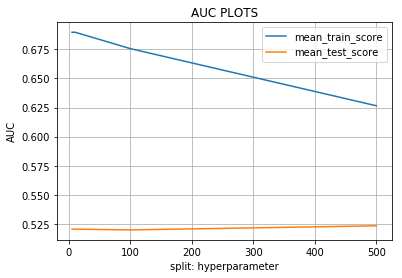

In [0]:
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(max_depth=50,min_samples_leaf=25,class_weight='balanced')
parameters={'min_samples_split':[5,10,100,500]}
clf=GridSearchCV(dt,parameters,cv=5,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)


results=pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_min_samples_split'])


k=results['param_min_samples_split']
y1=results['mean_train_score']
y2=results['mean_test_score']
plt.plot(k,y1)
plt.plot(k,y2)
plt.legend()
plt.xlabel("split: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

In [0]:
clf.best_params_

{'min_samples_split': 500}

In [0]:
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(min_samples_split=50,min_samples_leaf=230,class_weight='balanced')
parameters={'min_samples_split':[5,10,100,500],'max_depth':[1, 5, 10, 50, 100, 500, 1000],'min_samples_leaf':[250]}
clf=GridSearchCV(dt,parameters,cv=3,scoring='roc_auc',return_train_score=True)


clf.fit(X_tr,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=230,
                                              min_samples_split=50,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000],
                         'min_samples_leaf': [250],
     

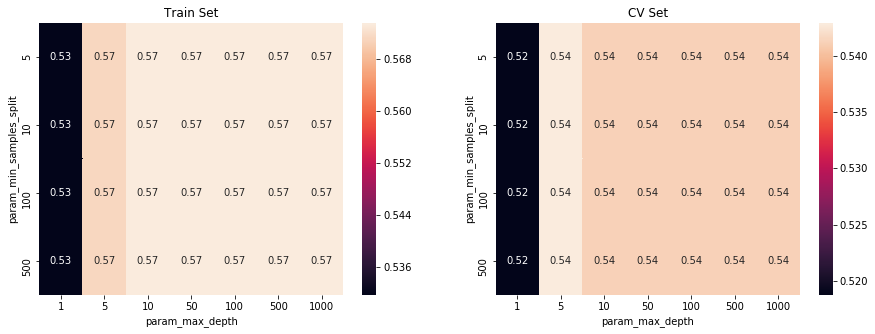

In [0]:
max_scores=pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split','param_max_depth',]).max().unstack()[['mean_test_score', 'mean_train_score']]
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(max_scores.mean_train_score,annot=True,fmt='.2g',ax=ax[0])
sns.heatmap(max_scores.mean_test_score,annot=True,fmt='.2g',ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

## The best DEPTH is selected based on maximum CV AUC and minimum difference between train and test accuracy as DEPTH=500 and SPLIT=100

# Fitting the best hyperparameters

In [0]:
dt = tree.DecisionTreeClassifier(max_depth=50,min_samples_split=100,class_weight='balanced')
dt.fit(X_tr, y_train)
y_train_pred = batch_predict(dt, X_tr)    
y_cv_pred = batch_predict(dt, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_cv_pred)

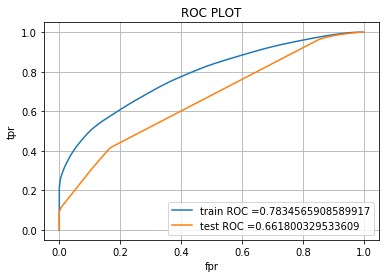

In [0]:
from sklearn.metrics import roc_curve, auc

dt = tree.DecisionTreeClassifier(max_depth=50,min_samples_split=100,class_weight='balanced')
dt.fit(X_tr, y_train)
y_train_pred = batch_predict(dt, X_tr)    
y_cv_pred = batch_predict(dt, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_cv_pred)

plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC PLOT")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) is = 0.28013308847753504 for threshold = 0.488


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

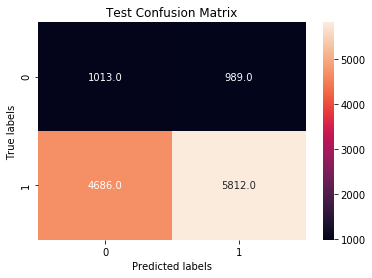

In [103]:

best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
pred=predict_with_best_t(y_cv_pred, best_t)
b=confusion_matrix(y_test,pred, labels)
ax= plt.subplot()
sns.heatmap(b, annot=True,fmt='.1f', ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Test Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1]); ax.yaxis.set_ticklabels([0,1])

## FINDING FALSE POSITIVES INDICES

In [104]:
I=set()
for i in range(0,len(y_test)):
    if pred[i]==1 and y_test[i]==0:
        I.add(i)    
print('Total number of false positives',len(I))

Total number of false positives 989


## Finding the false positives 

In [0]:
#find the false positives of essay,price and teacher previously submitted projets
fp_essay=[]
fp_price=[]
fp_previous_projects=[]
for i in I:
    fp_essay.append(X_test.iloc[i].essay.split(" "))
    fp_price.append(X_test.iloc[i].price)
    fp_previous_projects.append(X_test.iloc[i].teacher_number_of_previously_posted_projects)

fp_price=np.asarray(fp_price)

fp_previous_projects=np.asarray(fp_previous_projects)

## Plotting Word cloud of false positive words

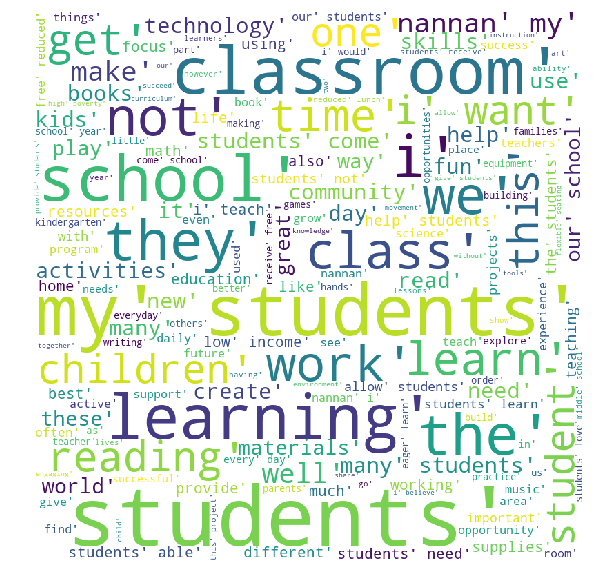

In [106]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in fp_essay:
    val = str(val)
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    for words in tokens: 
        comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)      
plt.show()

## BOX PLOT

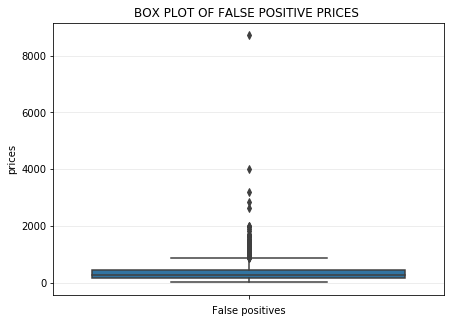

In [107]:
import seaborn as sns
fig, ax1 = plt.subplots(figsize=(7, 5))
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
a=sns.boxplot(y=fp_price).set_title('BOX PLOT OF FALSE POSITIVE PRICES ')
plt.ylabel('prices')
plt.xlabel('False positives')
plt.show()

## PDF

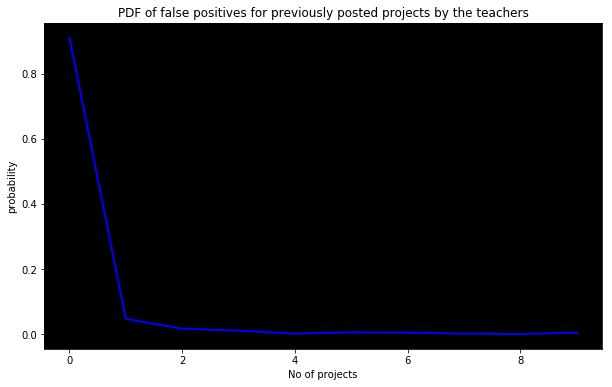

In [108]:
counts, bin_edges = np.histogram(fp_previous_projects, bins=10, 
                                 density = True)
pdf=counts/sum(counts)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('black')
plt.plot(pdf,'b',linewidth=2)
plt.xlabel('No of projects')
plt.ylabel('probability')
plt.title(label='PDF of false positives for previously posted projects by the teachers')
plt.show()
print('='*100)

##  <h1><center>TOP 5000 FEATURES </center></h1>

# Building model on top 5000 important features and finding the accuracy of the model

In [109]:
X_tr = hstack((X_train_grade_ohe,X_train_subject_ohe,X_train_subject_subcategories_ohe,X_train_previously_posted_projects_norm,X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_price_norm,X_train_neg_norm,X_train_neu_norm,X_train_pos_norm,X_train_compound_norm)).tocsr()
X_cv = hstack((X_cv_grade_ohe,X_cv_subject_ohe,X_cv_subject_subcategories_ohe,X_cv_essay_tfidf,X_cv_previously_posted_projects_norm, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_price_norm,X_cv_neg_norm,X_cv_neu_norm,X_cv_pos_norm,X_cv_compound_norm)).tocsr()
X_te = hstack((X_test_grade_ohe,X_test_subject_ohe,X_test_subject_subcategories_ohe,X_test_essay_tfidf,X_test_previously_posted_projects_norm, X_test_state_ohe, X_test_teacher_ohe, X_test_price_norm,X_test_neg_norm,X_test_neu_norm,X_test_pos_norm,X_test_compound_norm)).tocsr()
print(X_tr.shape)

(37500, 15011)


# Extracting top features

In [110]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_tr,y_train)
top5000tr=X_tr[:,dt.feature_importances_.argsort()[::-1][:5000]]
top5000cv=X_cv[:,dt.feature_importances_.argsort()[::-1][:5000]]
top5000te=X_te[:,dt.feature_importances_.argsort()[::-1][:5000]]
print(top5000te.shape)

(12500, 5000)


# Hyperparameter Tuning

100%|████████████████████████████████████████████| 6/6 [00:42<00:00, 10.43s/it]


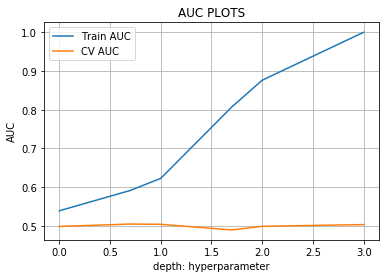

In [0]:
train_auc = []
cv_auc = []
depth=[1,5,10,50,100,1000]
for i in tqdm(depth):
    dt = tree.DecisionTreeClassifier(max_depth=i)
    dt.fit(top5000tr, y_train)
    
    y_train_pred = batch_predict(dt,top5000tr )    
    y_cv_pred = batch_predict(dt, top5000te)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_test, y_cv_pred))
plt.plot(np.log10(depth), train_auc, label='Train AUC')
plt.plot(np.log10(depth), cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("depth: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.grid()
plt.show()
    

100%|████████████████████████████████████████████| 4/4 [01:41<00:00, 25.33s/it]


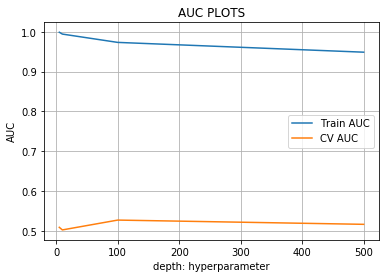

In [0]:
train_auc = []
cv_auc = []
split=[5,10,100,500]
for i in tqdm(split):
    dt = tree.DecisionTreeClassifier(min_samples_split=i ,max_depth=500)
    dt.fit(top5000tr, y_train)
    
    y_train_pred = batch_predict(dt, top5000tr)    
    y_cv_pred = batch_predict(dt, top5000te)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_test, y_cv_pred))
plt.plot(split, train_auc, label='Train AUC')
plt.plot(split, cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("split: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.grid()
plt.show()
    

In [0]:
from  sklearn.tree import DecisionTreeClassifier as dt
dt=dt(class_weight='balanced')
parameters={'min_samples_split':[5,10,100,500],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}
clf=GridSearchCV(dt,parameters,cv=3,scoring='roc_auc',return_train_score=True)

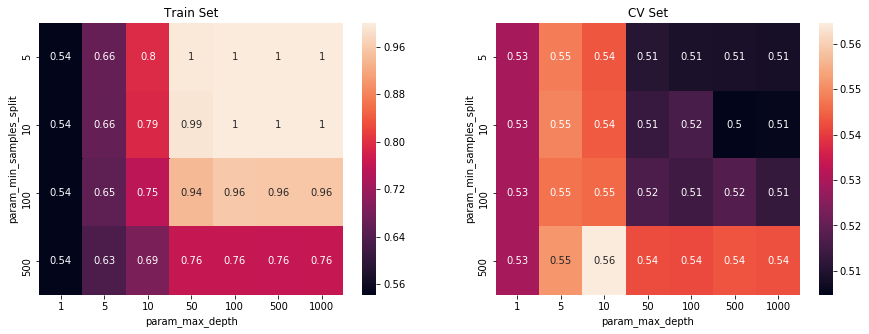

In [0]:
clf.fit(X_tr,y_train)

max_scores=pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split','param_max_depth',]).max().unstack()[['mean_test_score', 'mean_train_score']]
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(max_scores.mean_train_score,annot=True,fmt='.2g',ax=ax[0])
sns.heatmap(max_scores.mean_test_score,annot=True,fmt='.2g',ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

## The best DEPTH is selected based on maximum CV AUC and minimum difference between train and test accuracy as DEPTH=500 and SPLIT=500

# Training the best model

In [0]:

dt = tree.DecisionTreeClassifier(max_depth=500,min_samples_split=500,class_weight='balanced')
dt.fit(top5000tr, y_train)
y_train_pred = batch_predict(dt, top5000tr)    
y_cv_pred = batch_predict(dt, top5000te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_cv_pred)

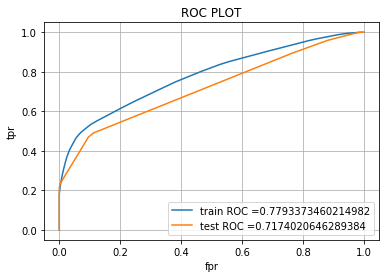

In [0]:
from sklearn.metrics import roc_curve, auc

dt = tree.DecisionTreeClassifier(max_depth=500,min_samples_split=500,class_weight='balanced')
dt.fit(top5000tr, y_train)
y_train_pred = batch_predict(dt, top5000tr)    
y_cv_pred = batch_predict(dt, top5000te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_cv_pred)

plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC PLOT")
plt.grid()
plt.show()

# TREE VISUALIZATION for TOP 5000 FEATURES

In [0]:
i=np.argsort(dt.feature_importances_)
print(len(i))
F=[]
for j in i:
    F.append(l2[j])

5000


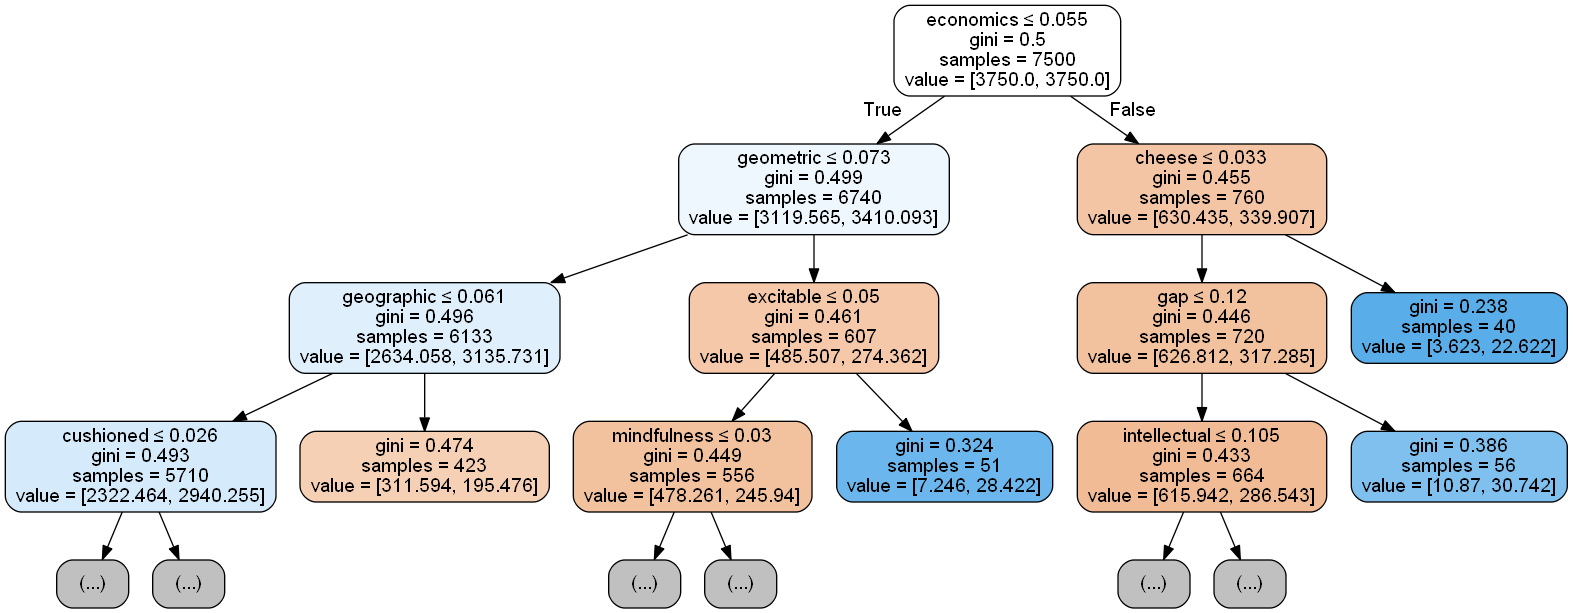

In [0]:
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True,max_depth=3,feature_names=F)
                
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

the maximum value of tpr*(1-fpr) is = 0.08765953041053061 for threshold = 0.323


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

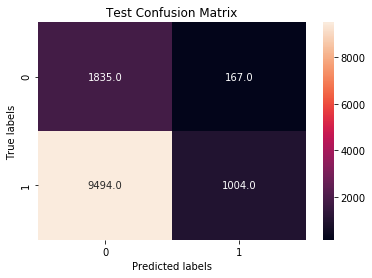

In [112]:
#PLOTTING TEST CONFUSION MATRIX
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
pred=predict_with_best_t(y_cv_pred, best_t)
b=confusion_matrix(y_test,pred, labels)
     
ax= plt.subplot()
sns.heatmap(b, annot=True,fmt='0.1f', ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Test Confusion Matrix'); 
ax.xaxis.set_ticklabels([0, 1]); ax.yaxis.set_ticklabels([0,1])

## False positive indices

In [113]:
I=set()
for i in range(0,len(y_test)):
    if pred[i]==1 and y_test[i]==0:
        I.add(i)    
print('Total number of false positives',len(I))

Total number of false positives 167


In [0]:
#find the false positives of essay,price and teacher previously submitted projets
fp_essay=[]
fp_price=[]
fp_previous_projects=[]
for i in I:
    fp_essay.append(X_test.iloc[i].essay.split(" "))
    fp_price.append(X_test.iloc[i].price)
    fp_previous_projects.append(X_test.iloc[i].teacher_number_of_previously_posted_projects)

fp_price=np.asarray(fp_price)

fp_previous_projects=np.asarray(fp_previous_projects)

## Plotting Word cloud

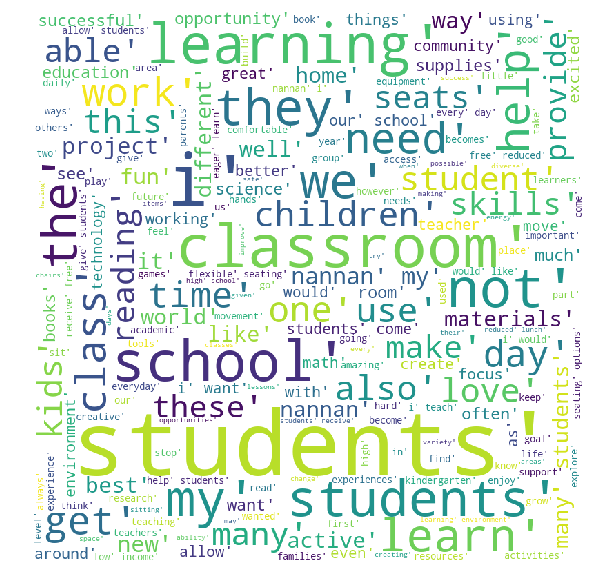

In [115]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in fp_essay:
    val = str(val)
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    for words in tokens: 
        comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)      
plt.show()

## BOX PLOT

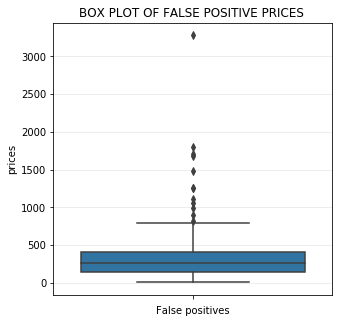

In [116]:
import seaborn as sns
fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
a=sns.boxplot(y=fp_price).set_title('BOX PLOT OF FALSE POSITIVE PRICES ')
plt.ylabel('prices')
plt.xlabel('False positives')
plt.show()

## PDF

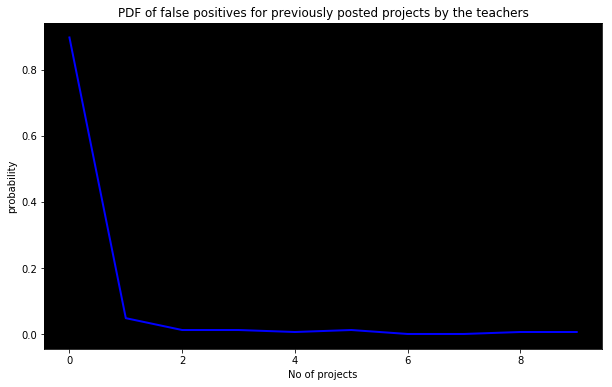

In [119]:
counts, bin_edges = np.histogram(fp_previous_projects, bins=10, 
                                 density = True)
pdf=counts/sum(counts)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('black')
plt.plot(pdf,'b',linewidth=2)
plt.xlabel('No of projects')
plt.ylabel('probability')

plt.title(label='PDF of false positives for previously posted projects by the teachers')
plt.show()

# Comparing the accuracy of models built using different featurization techniques

In [0]:
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers = ["VECTORIZER", "Model", "Hyperparameter(DEPTH)" , "Hyperparameter(SPLIT)" , "TRAIN AUC","TEST AUC"]
table.append_row(["BOW", "Brute", 500,500,0.60,0.59])
table.append_row(["TFIDF", "Brute", 100,5,0.89,0.71])
table.append_row(["AVG W2V", "Brute",100,10,0.95,0.67])
table.append_row(["TFIDF W2V", "Brute", 50,100,0.78,0.66])
table.append_row(["TOP 5000 FEATURES TFIDF W2V", "Brute", 500,500,0.78,0.71])
print(table)

+------------------+--------+-------------+-------------+-----------+----------+
|    VECTORIZER    | Model  | Hyperparame | Hyperparame | TRAIN AUC | TEST AUC |
|                  |        | ter(DEPTH)  | ter(SPLIT)  |           |          |
+------------------+--------+-------------+-------------+-----------+----------+
|       BOW        | Brute  |     500     |     500     |    0.6    |   0.59   |
+------------------+--------+-------------+-------------+-----------+----------+
|      TFIDF       | Brute  |     100     |      5      |   0.89    |   0.71   |
+------------------+--------+-------------+-------------+-----------+----------+
|     AVG W2V      | Brute  |     100     |     10      |   0.95    |   0.67   |
+------------------+--------+-------------+-------------+-----------+----------+
|    TFIDF W2V     | Brute  |     50      |     100     |   0.78    |   0.66   |
+------------------+--------+-------------+-------------+-----------+----------+
| TOP 5000 FEATURE | Brute  

# TFIDF Vectorizer proves to be the best with TEST ACCURACY =71%